# 3. 직접 단어 개수를 설정해서 사용.
3000, 7000, 15000에서 진행

In [1]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

2024-07-04 08:33:31.923101: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-04 08:33:32.868481: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 중복 사용 함수로 생성
사용할 모델
- 나이브 베이즈 분류기
- CNB
- 로지스틱 회귀
- 서포트 벡터 머신
- 결정 트리
- 랜덤 포레스트
- 그래디언트 부스팅 트리
- 보팅

In [2]:
# 데이터 분포 확인
def check_distribute(X, y):
    print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in X)))
    print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, X))/len(X)))

    plt.hist([len(s) for s in X], bins=50)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()

    fig, axe = plt.subplots(ncols=1)
    fig.set_size_inches(11,5)
    sns.countplot(x=y)
    plt.show()

    unique_elements, counts_elements = np.unique(y, return_counts=True)
    print("각 클래스 빈도수:")
    print(np.asarray((unique_elements, counts_elements)))

In [3]:
# index_to_word 생성
def create_index_to_word(module):
    # word_index 생성
    word_index = module.get_word_index(path = 'reuters_word_index.json')

    # index_to_word 생성
    index_to_word = { index + 3: word for word, index in word_index.items() }
    for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
        index_to_word[index]=token

    return index_to_word

# 원본 뉴스 데이터로 복원
def index_to_corpus(X, index_to_word):
    # decode
    decoded = []
    for i in range(len(X)):
        t = ' '.join([index_to_word[index] for index in X[i]])
        decoded.append(t)

    return decoded

In [4]:
# 벡터화
def vectorizer(train, test):
    dtmvector = CountVectorizer()
    x_train_dtm = dtmvector.fit_transform(train)

    tfidf_transformer = TfidfTransformer()
    tfidfv = tfidf_transformer.fit_transform(x_train_dtm)

    x_text_dtm = dtmvector.transform(test)
    tfidfv_test = tfidf_transformer.transform(x_text_dtm)

    return tfidfv, tfidfv_test

In [5]:
# confusion_matrix
def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
  df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
  fig = plt.figure(figsize=(12,12))
  heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
  plt.ylabel('label')
  plt.xlabel('predicted value')

In [6]:
models = {
    'Multinomial Naive Bayes Classifier': MultinomialNB(),
    'Complement Naive Bayes Classifier': ComplementNB(),
    'LogisticRegression': LogisticRegression(C=10000, penalty='l2', max_iter=3000),
    'LinearSupport Vector Mavhine': LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=0),
    'Random Forest': RandomForestClassifier(n_estimators = 5, max_depth = 10, random_state=0),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=0),
    'Voting': VotingClassifier(estimators=[('lr', LogisticRegression(C=10000, penalty='l2', max_iter=3000)), ('CBN', ComplementNB()), ('GBM', GradientBoostingClassifier(random_state=0))], voting='soft')
}
model_names = models.keys()

def build_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    predicted = model.predict(X_test)
    print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
    print(classification_report(y_test, predicted, zero_division=0))
    graph_confusion_matrix(model, X_test, y_test)

# 3000개 단어 사용

In [7]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=3000, test_split=0.2)

## 데이터 분포 확인

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


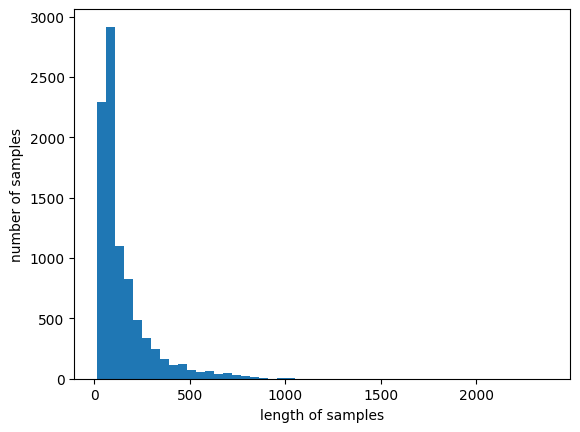

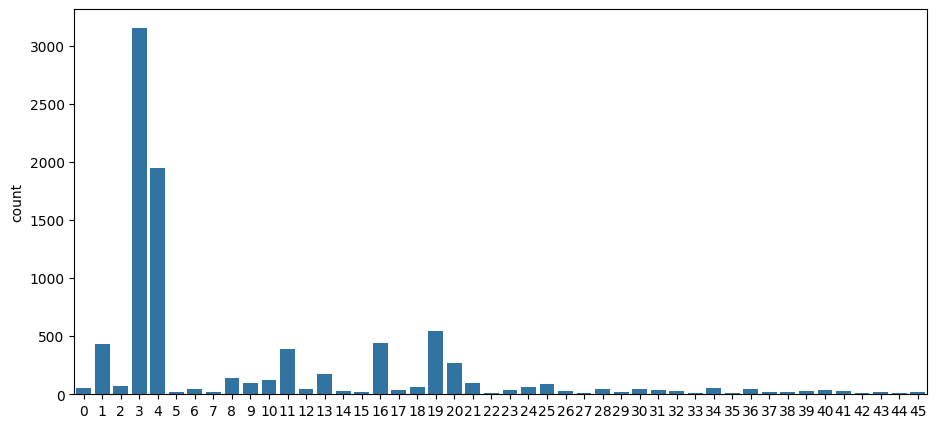

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


In [8]:
check_distribute(x_train, y_train)

## 원본 데이터로 되돌리기

In [9]:
index_to_word = create_index_to_word(reuters)
x_train = index_to_corpus(x_train, index_to_word)
print('X_train:', len(x_train))
print('\n'.join(x_train[:5]))

x_test = index_to_corpus(x_test, index_to_word)
print('X_test:', len(x_test))
print('\n'.join(x_test[:5]))

X_train: 8982
<sos> <unk> <unk> said as a result of its december acquisition of <unk> co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and <unk> operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
<sos> <unk> de <unk> sa lt <unk> <unk> and lt <unk> overseas corp of chicago have each taken 50 pct <unk> in <unk> company sa <unk> factors <unk> de <unk> said in a statement it gave no financial details of the transaction sa <unk> <unk> turnover in 1986 was 17 5 billion belgian francs reuter 3
<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 <unk> 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share reflect the two for one

## 벡터화

In [10]:
tfidfv, tfidfv_test = vectorizer(x_train, x_test)

print(tfidfv.shape)
print(tfidfv_test.shape)

(8982, 2919)
(2246, 2919)


## 모델링

Multinomial Naive Bayes Classifier
정확도: 0.6874443455031166
              precision    recall  f1-score   support

           0       1.00      0.25      0.40        12
           1       0.49      0.82      0.61       105
           2       0.00      0.00      0.00        20
           3       0.88      0.88      0.88       813
           4       0.64      0.95      0.76       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.48      0.65        25
          10       1.00      0.10      0.18        30
          11       0.45      0.76      0.56        83
          12       0.00      0.00      0.00        13
          13       0.70      0.19      0.30        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.5

----------------------------------------------------------------------


Complement Naive Bayes Classifier
정확도: 0.7644701691896705
              precision    recall  f1-score   support

           0       0.75      0.50      0.60        12
           1       0.64      0.85      0.73       105
           2       0.83      0.50      0.62        20
           3       0.92      0.89      0.90       813
           4       0.74      0.93      0.82       474
           5       0.00      0.00      0.00         5
           6       0.86      0.86      0.86        14
           7       1.00      0.67      0.80         3
           8       0.64      0.18      0.29        38
           9       0.82      0.92      0.87        25
          10       0.93      0.83      0.88        30
          11       0.52      0.78      0.62        83
          12       0.00      0.00      0.00        13
          13       0.68      0.62      0.65        37
          14       0.00      0.00      0.00         2
    

/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


정확도: 0.7493321460373998
              precision    recall  f1-score   support

           0       0.70      0.58      0.64        12
           1       0.74      0.71      0.72       105
           2       0.67      0.70      0.68        20
           3       0.87      0.88      0.88       813
           4       0.78      0.80      0.79       474
           5       0.50      0.20      0.29         5
           6       0.86      0.86      0.86        14
           7       1.00      0.67      0.80         3
           8       0.60      0.66      0.62        38
           9       0.76      0.76      0.76        25
          10       0.80      0.80      0.80        30
          11       0.59      0.69      0.64        83
          12       0.36      0.38      0.37        13
          13       0.47      0.54      0.50        37
          14       0.33      0.50      0.40         2
          15       0.67      0.44      0.53         9
          16       0.64      0.68      0.66        99
   

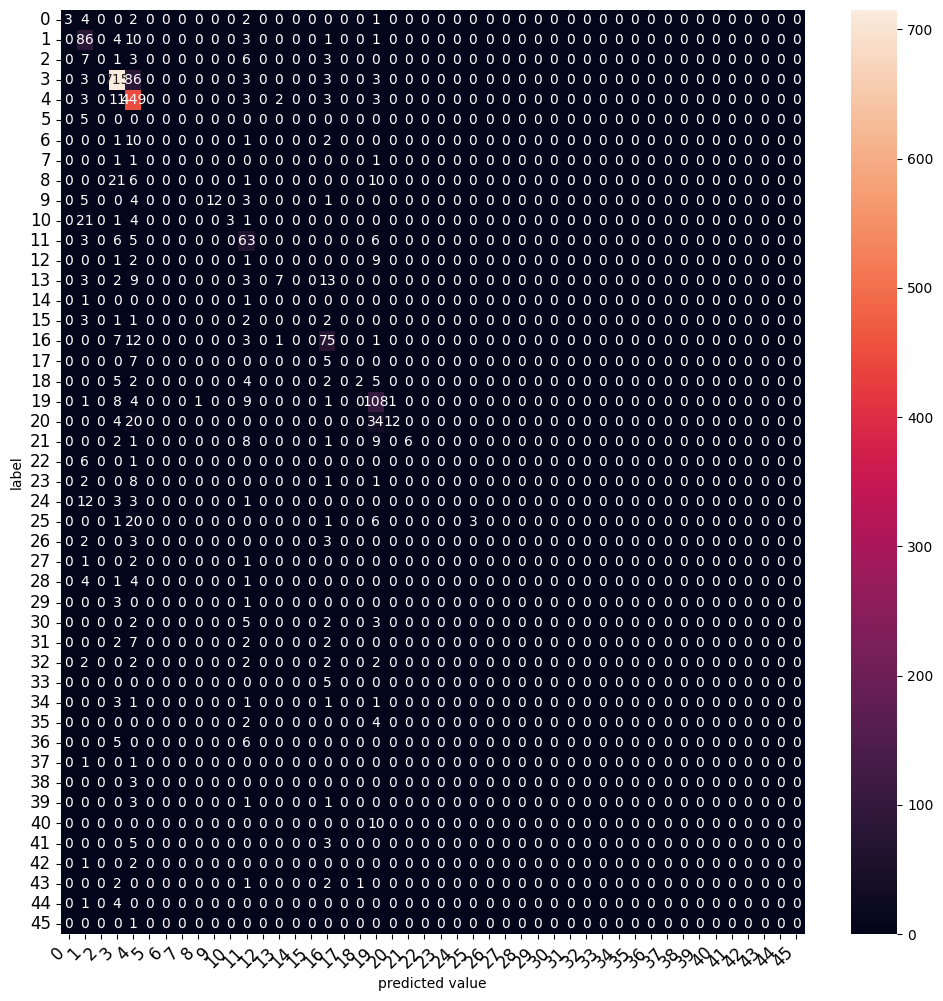

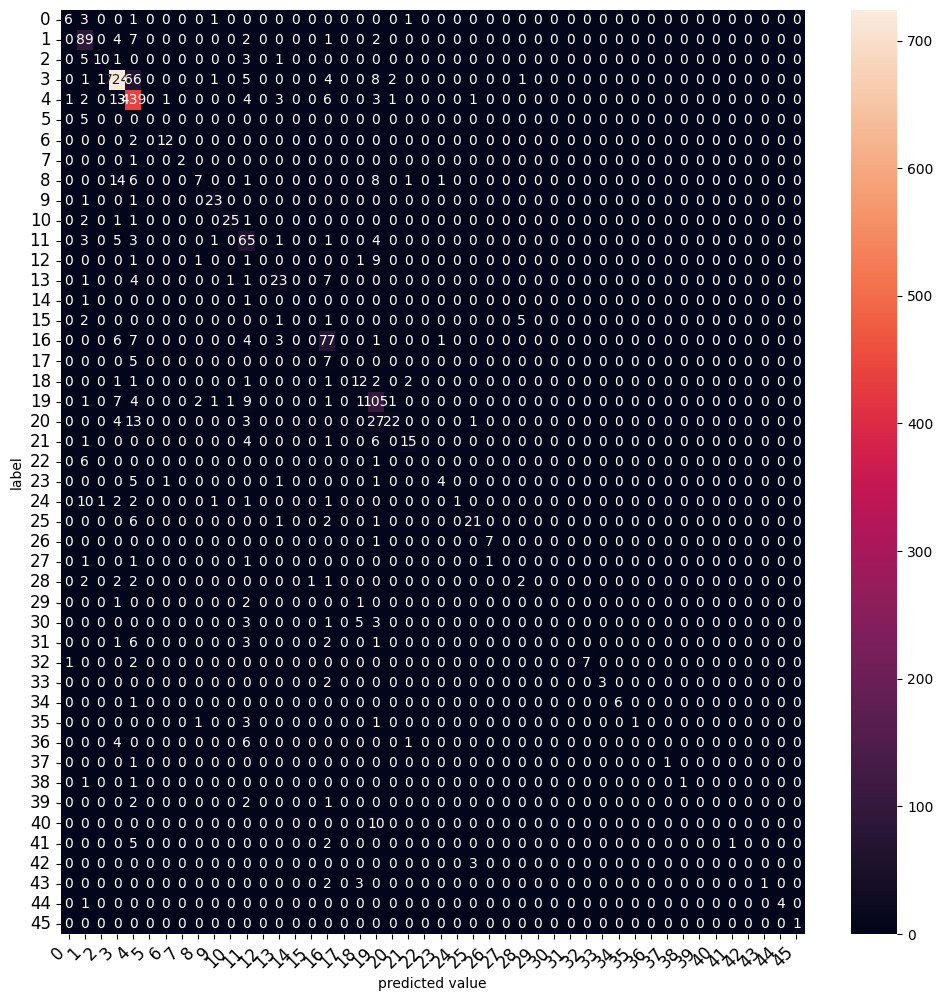

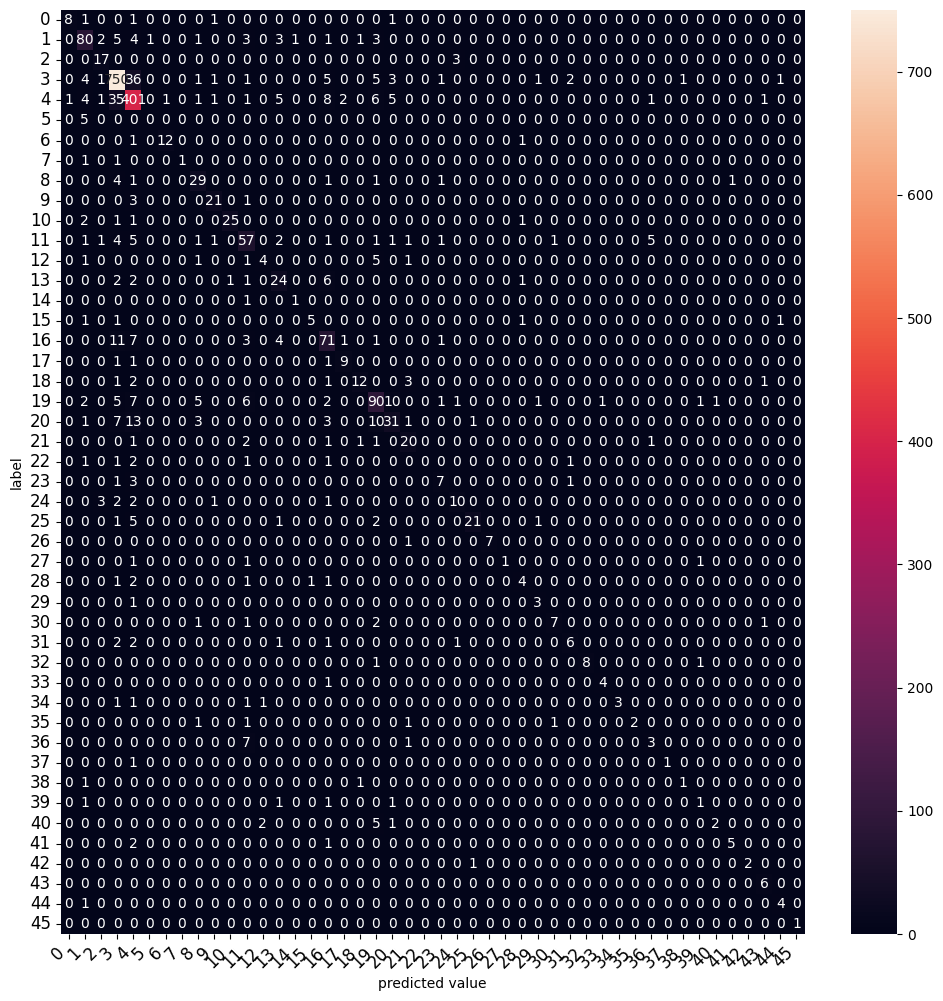

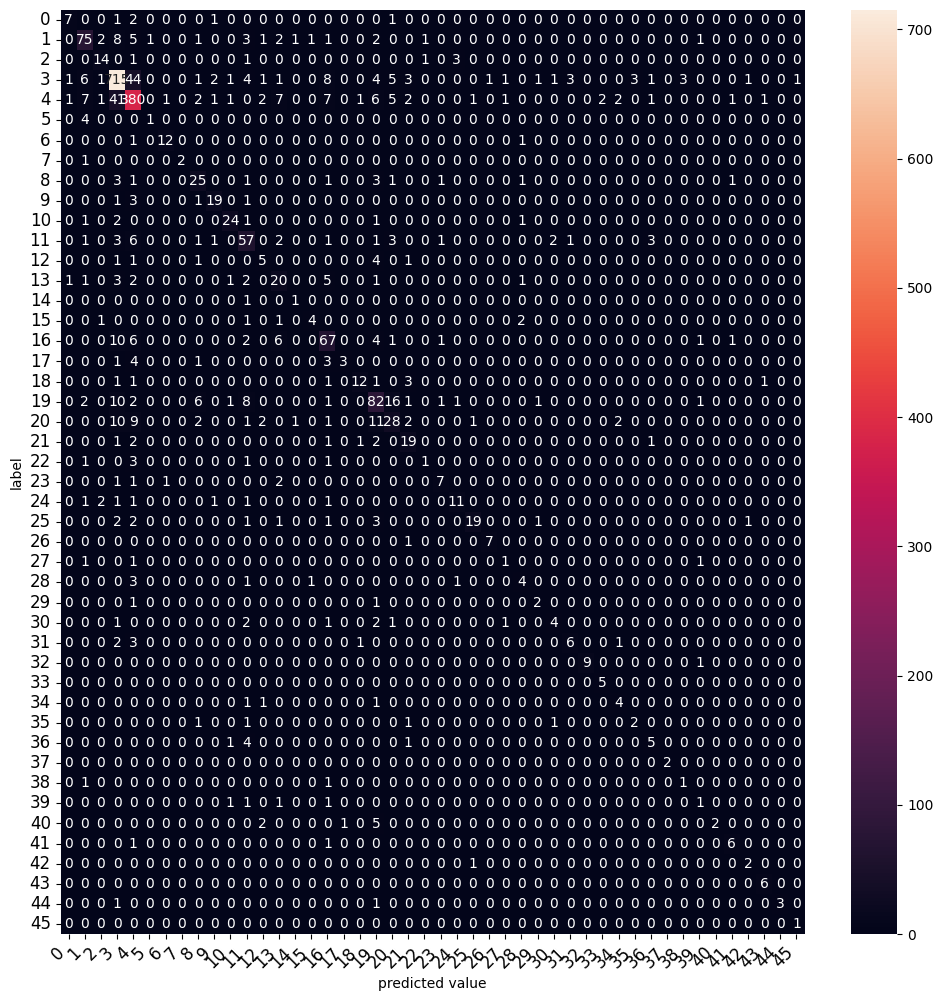

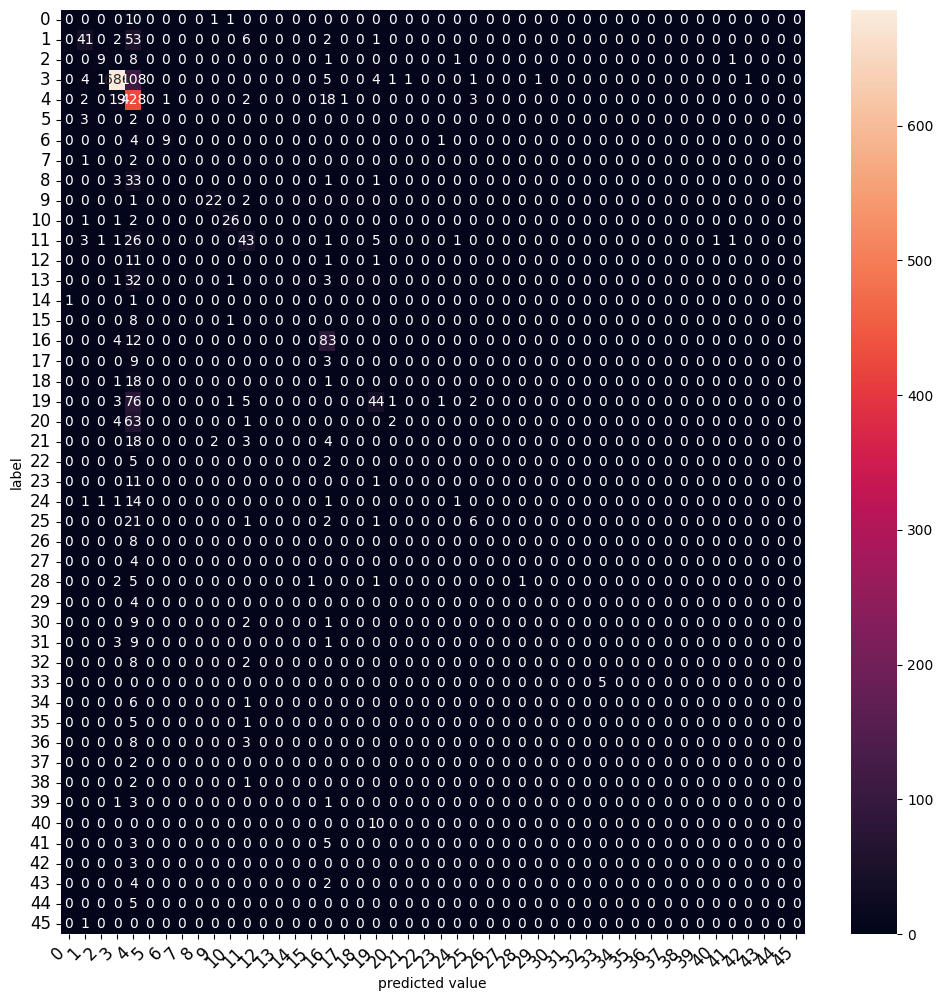

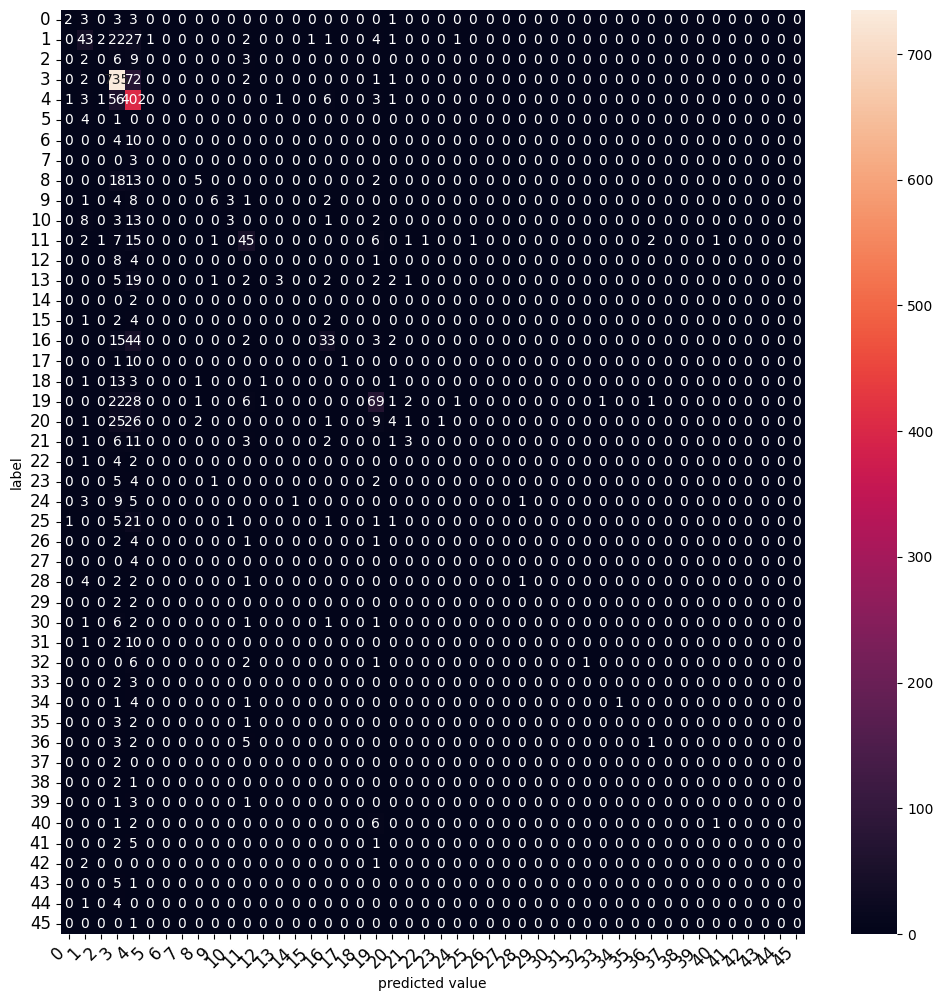

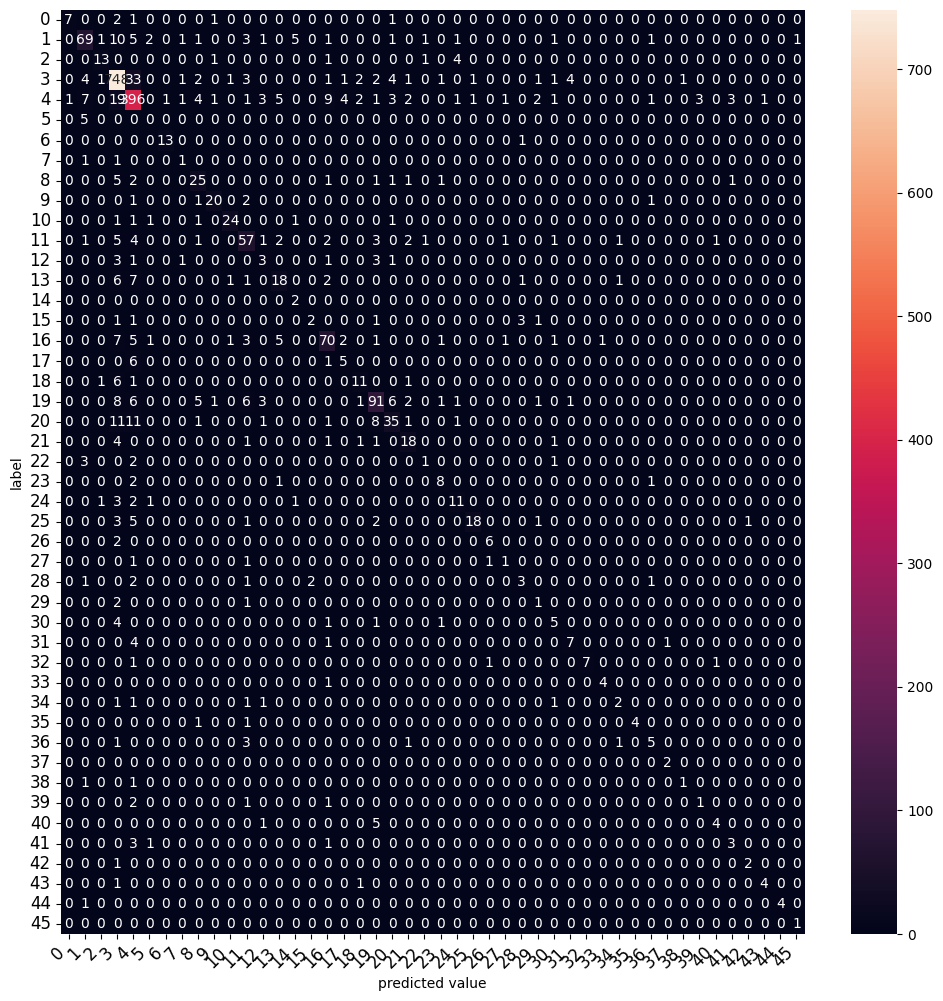

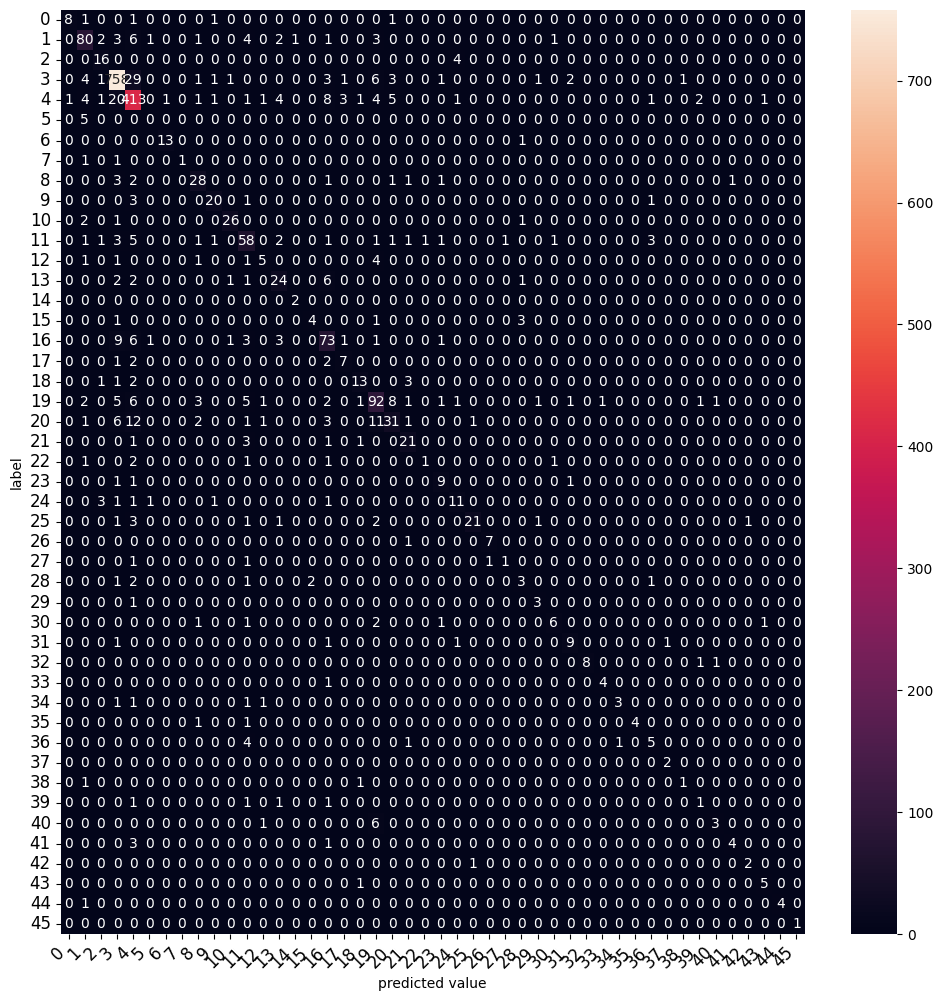

In [11]:
for model_name in model_names:
    print(model_name)
    build_model(models[model_name], tfidfv, y_train, tfidfv_test, y_test)
    print('-' * 70)
    print('\n')

Accuracy  
Multinomial Naive Bayes Classifier     0.6874443455031166  
Complement Naive Bayes Classifier      0.7644701691896705  
LogisticRegression                     0.7911843276936776  
LinearSupport Vector Mavhine           0.7493321460373998  
Decision Tree                          0.6260017809439002  
Random Forest                          0.6050756901157613  
Gradient Boosting Classifier           0.7715939447907391  
Voting                                 0.8063223508459484  
  
macro avg F1-score  
Multinomial Naive Bayes Classifier     0.14  
Complement Naive Bayes Classifier      0.44  
LogisticRegression                     0.63  
LinearSupport Vector Mavhine           0.59  
Decision Tree                          0.18  
Random Forest                          0.13  
Gradient Boosting Classifier           0.57  
Voting                                 0.65  

로지스틱회귀분석과 보팅, SVM의 결과가 좋음.

# 7000개 단어 사용

In [12]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=7000, test_split=0.2)

## 데이터 분포 확인

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


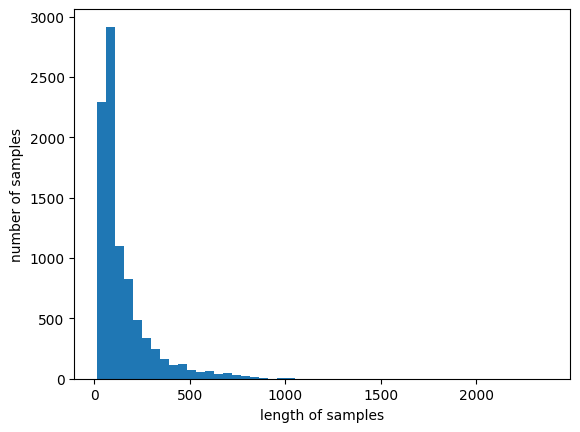

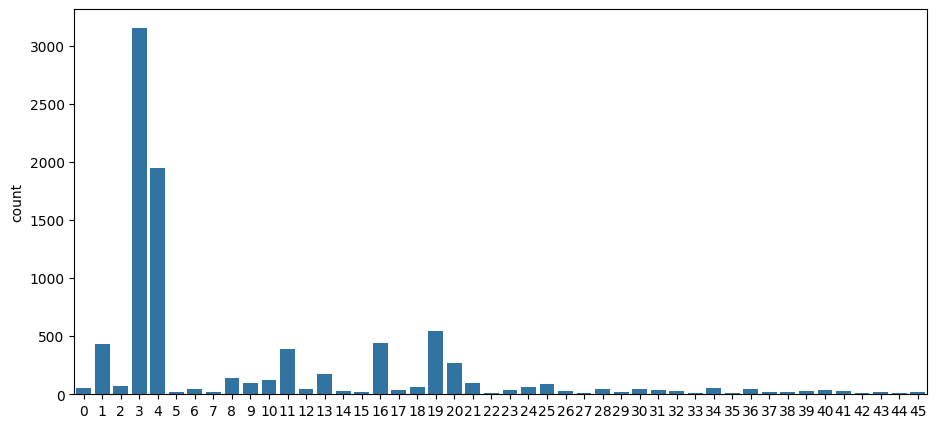

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


In [13]:
check_distribute(x_train, y_train)

## 원본 데이터로 되돌리기

In [14]:
index_to_word = create_index_to_word(reuters)
x_train = index_to_corpus(x_train, index_to_word)
print('X_train:', len(x_train))
print('\n'.join(x_train[:5]))

x_test = index_to_corpus(x_test, index_to_word)
print('X_test:', len(x_test))
print('\n'.join(x_test[:5]))

X_train: 8982
<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
<sos> generale de banque sa lt <unk> <unk> and lt heller overseas corp of chicago have each taken 50 pct stakes in <unk> company sa <unk> factors generale de banque said in a statement it gave no financial details of the transaction sa <unk> <unk> turnover in 1986 was 17 5 billion belgian francs reuter 3
<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share reflect the tw

## 벡터화

In [15]:
tfidfv, tfidfv_test = vectorizer(x_train, x_test)

print(tfidfv.shape)
print(tfidfv_test.shape)

(8982, 6807)
(2246, 6807)


## 모델링

Multinomial Naive Bayes Classifier
정확도: 0.6647373107747105
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.56      0.76      0.65       105
           2       0.00      0.00      0.00        20
           3       0.84      0.89      0.86       813
           4       0.55      0.95      0.70       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.16      0.28        25
          10       0.00      0.00      0.00        30
          11       0.53      0.69      0.60        83
          12       0.00      0.00      0.00        13
          13       1.00      0.05      0.10        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.6

정확도: 0.807212822796082
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.76      0.80      0.78       105
           2       0.71      0.75      0.73        20
           3       0.91      0.94      0.92       813
           4       0.81      0.86      0.84       474
           5       0.00      0.00      0.00         5
           6       0.93      0.93      0.93        14
           7       1.00      0.67      0.80         3
           8       0.61      0.66      0.63        38
           9       0.82      0.92      0.87        25
          10       0.93      0.87      0.90        30
          11       0.64      0.73      0.69        83
          12       0.50      0.31      0.38        13
          13       0.66      0.62      0.64        37
          14       0.67      1.00      0.80         2
          15       0.83      0.56      0.67         9
          16       0.68      0.74      0.71        99
    

/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


정확도: 0.7831700801424755
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       0.73      0.75      0.74       105
           2       0.76      0.80      0.78        20
           3       0.90      0.92      0.91       813
           4       0.82      0.82      0.82       474
           5       0.00      0.00      0.00         5
           6       0.81      0.93      0.87        14
           7       0.50      0.33      0.40         3
           8       0.63      0.71      0.67        38
           9       0.78      0.84      0.81        25
          10       0.89      0.80      0.84        30
          11       0.60      0.75      0.66        83
          12       0.36      0.31      0.33        13
          13       0.57      0.57      0.57        37
          14       1.00      0.50      0.67         2
          15       0.71      0.56      0.62         9
          16       0.64      0.73      0.68        99
   

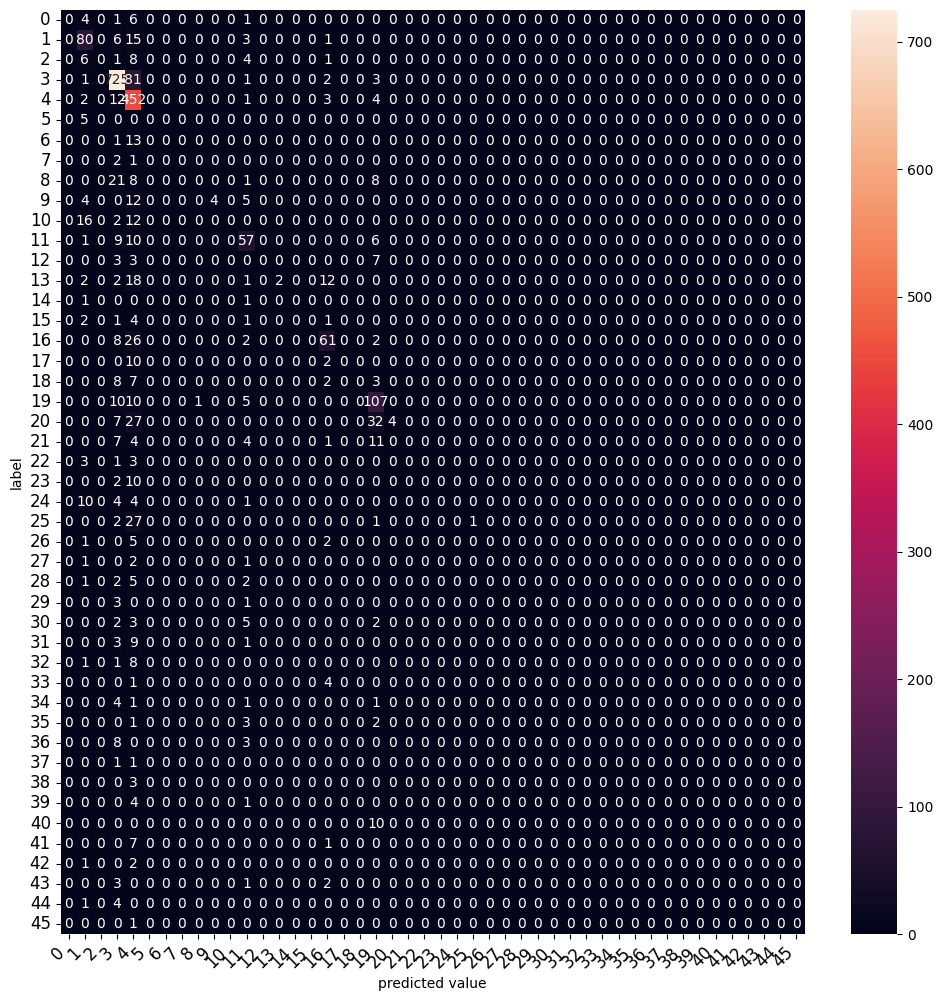

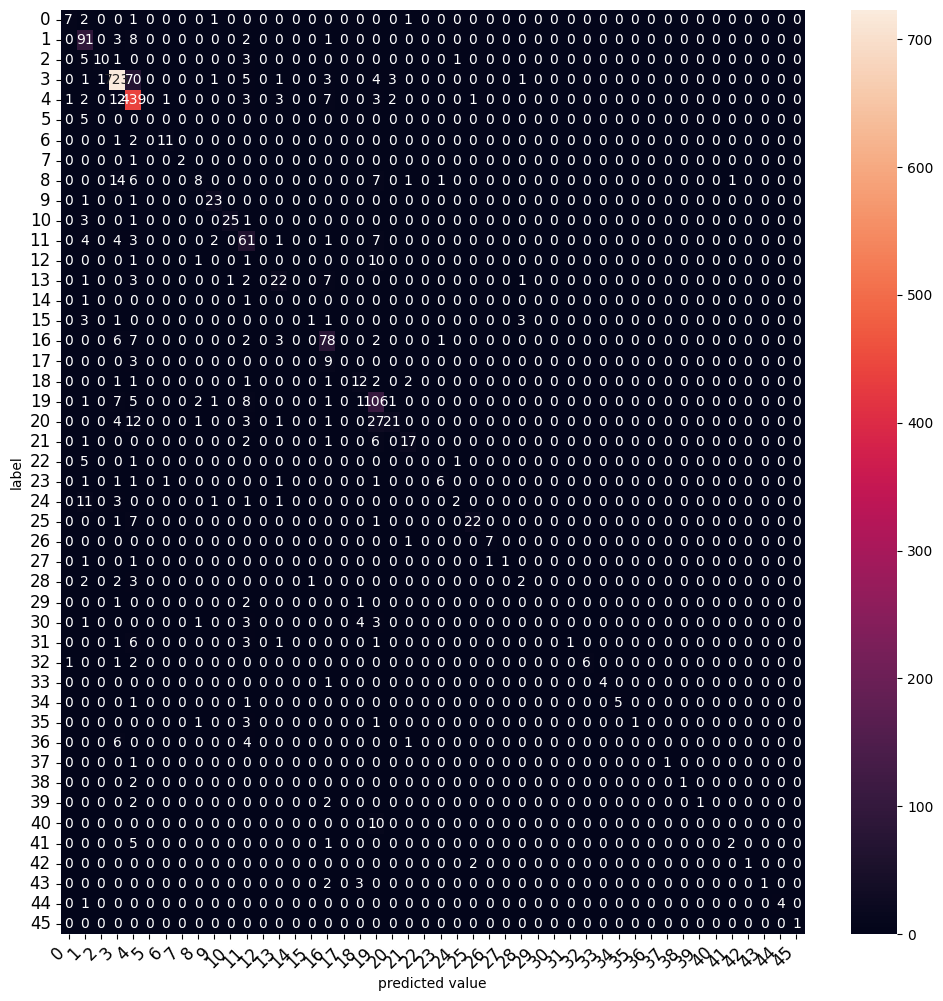

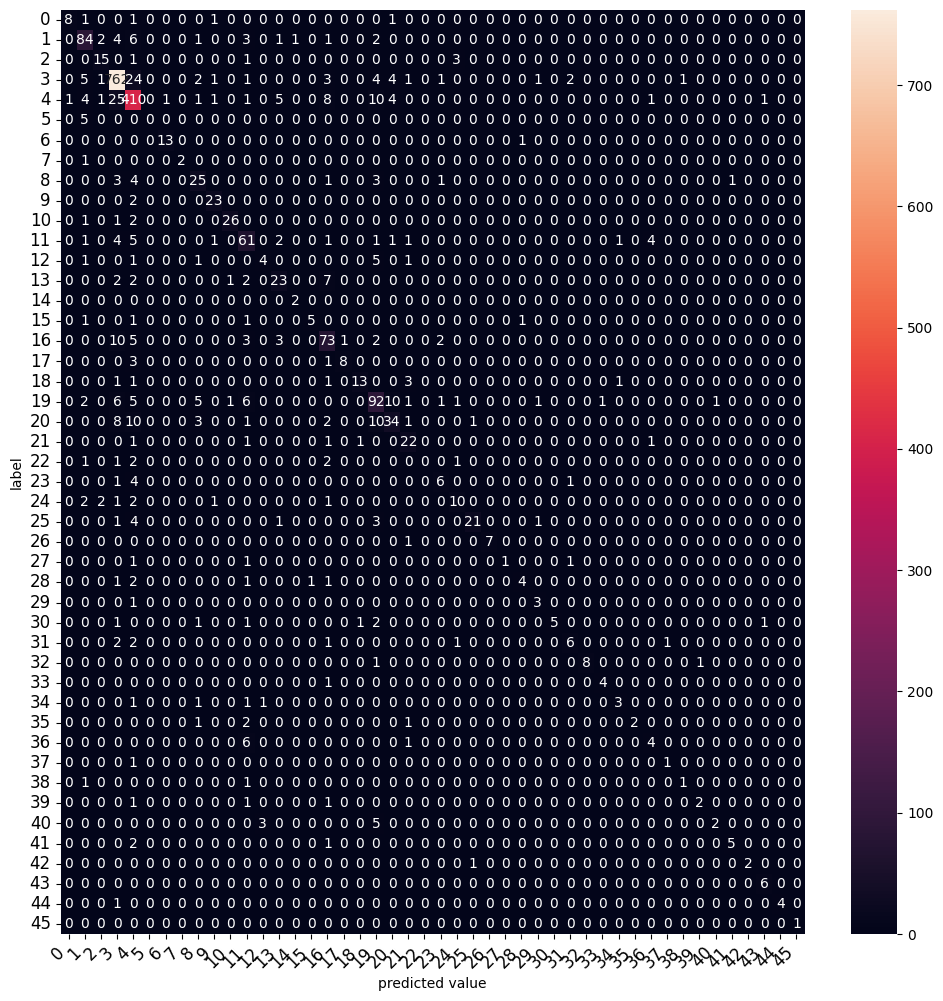

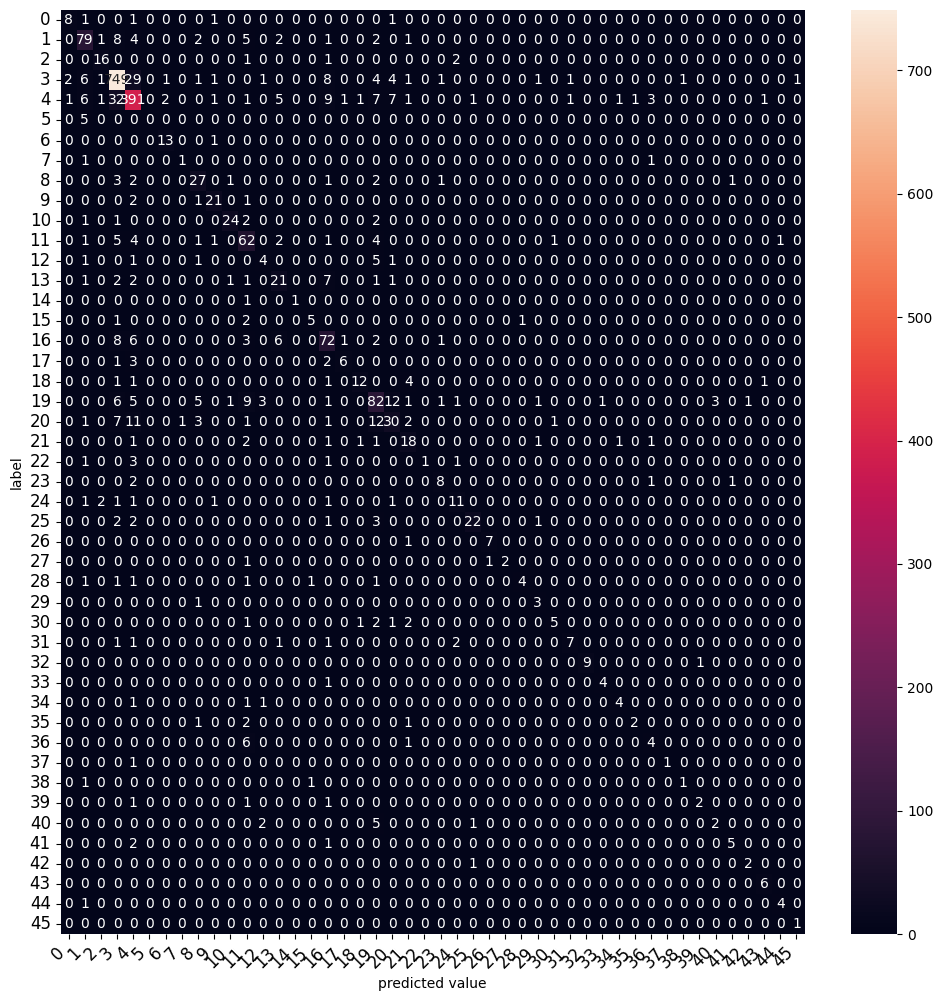

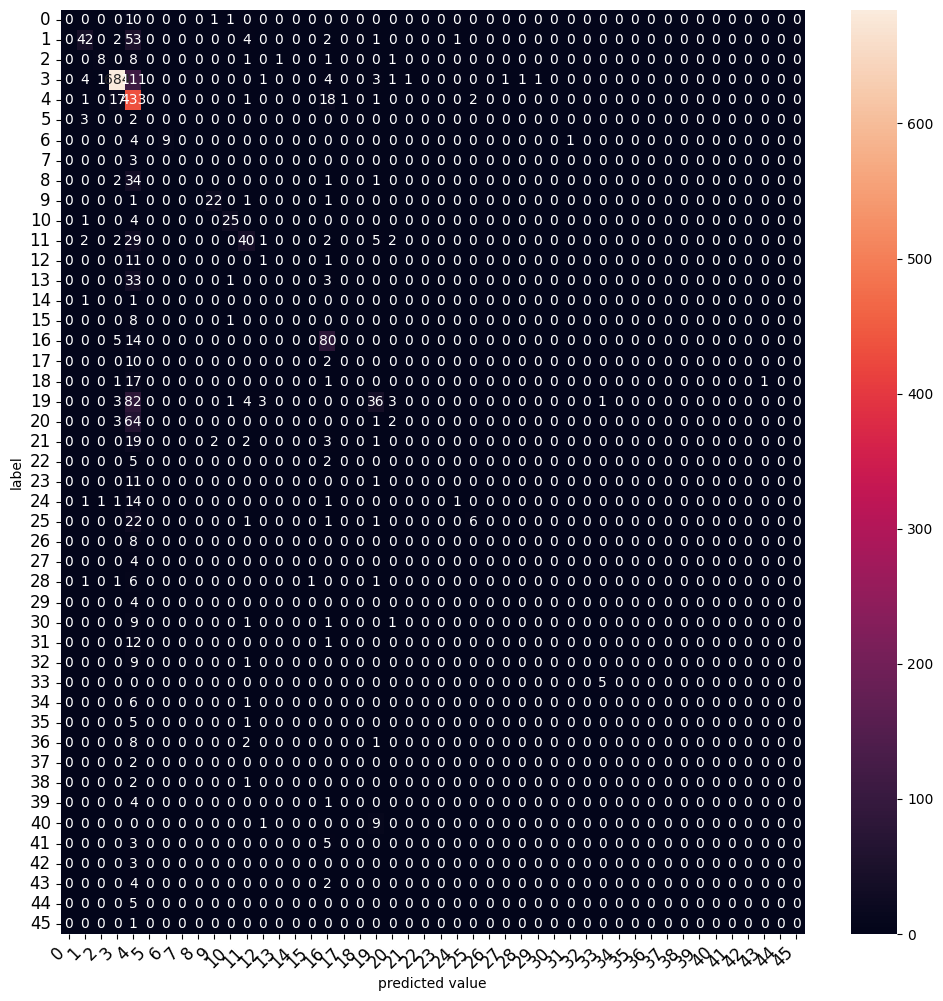

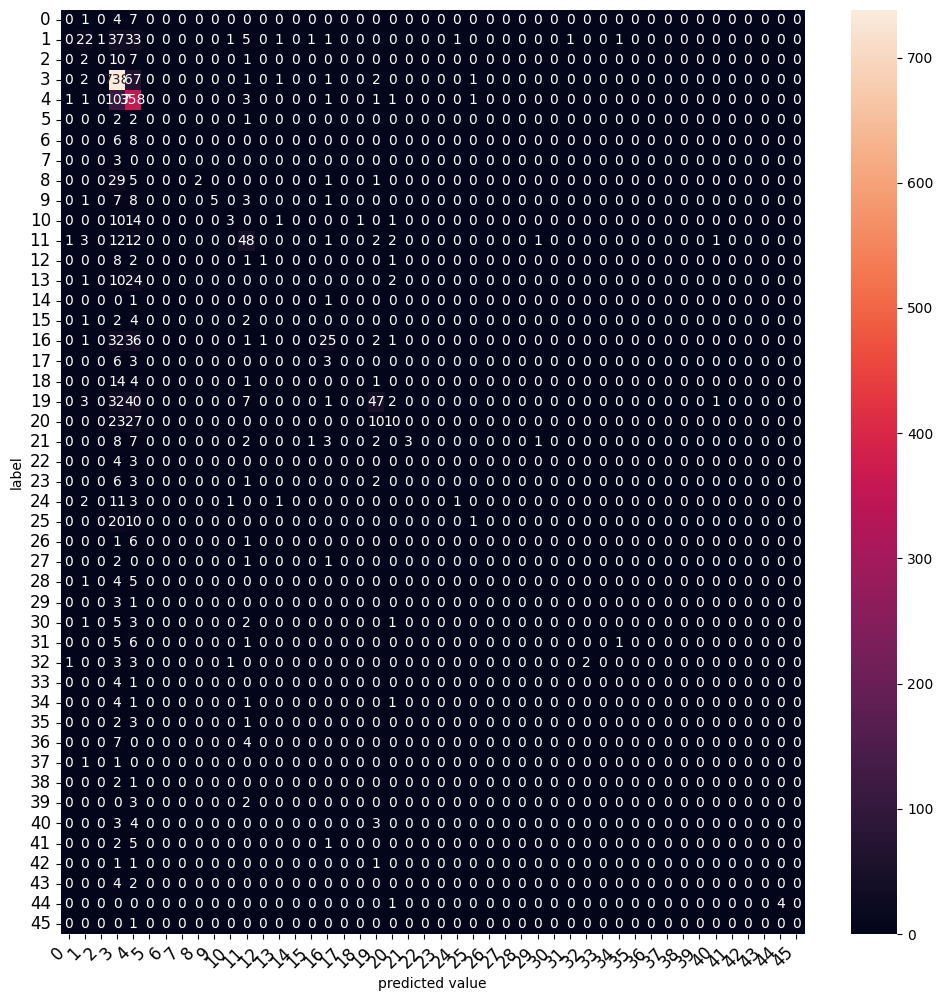

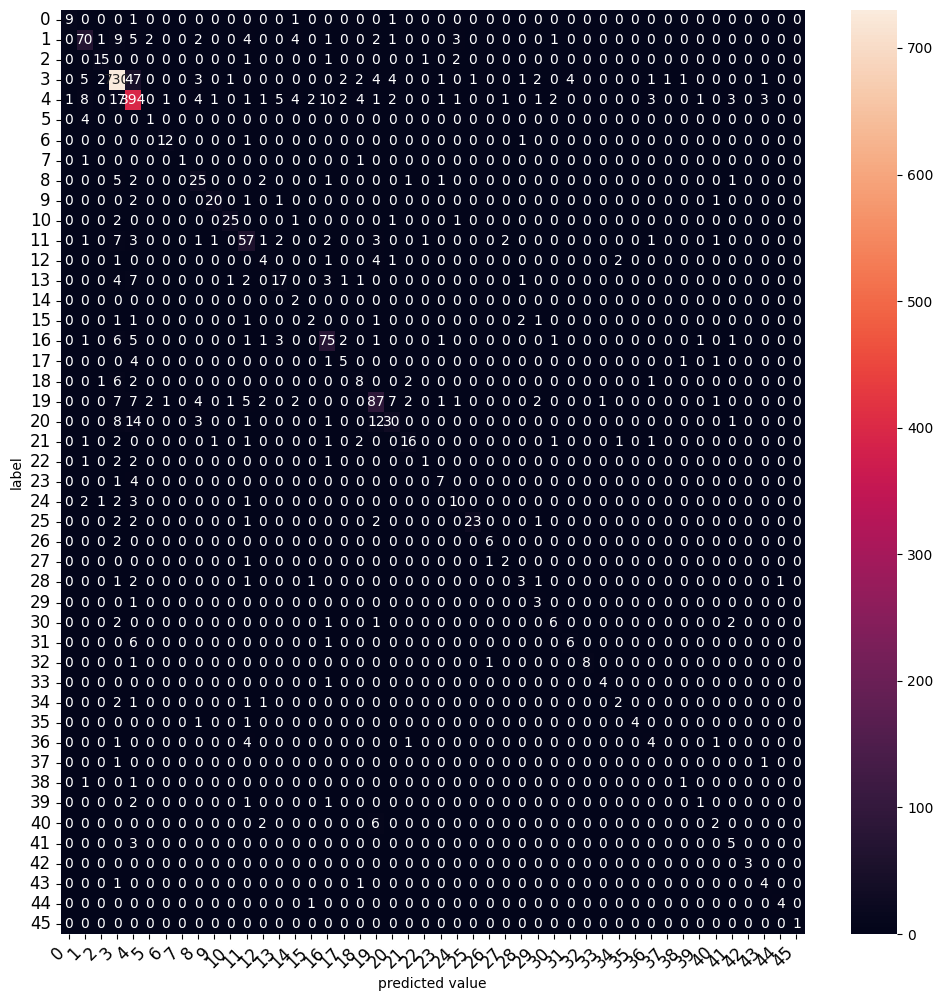

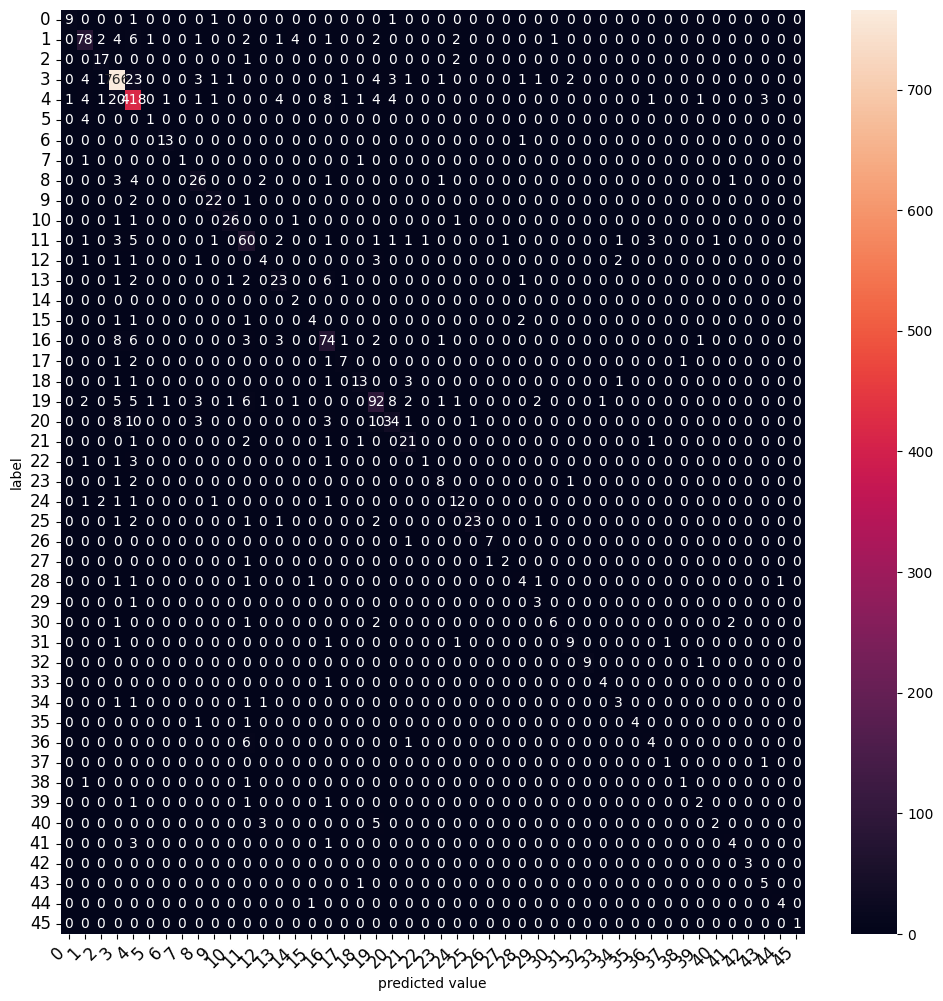

In [16]:
for model_name in model_names:
    print(model_name)
    build_model(models[model_name], tfidfv, y_train, tfidfv_test, y_test)
    print('-' * 70)
    print('\n')

# 15000개 단어 사용

In [17]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=15000, test_split=0.2)

## 데이터 분포 확인

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


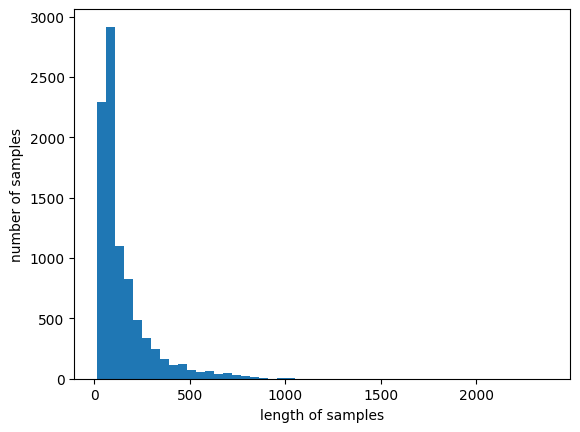

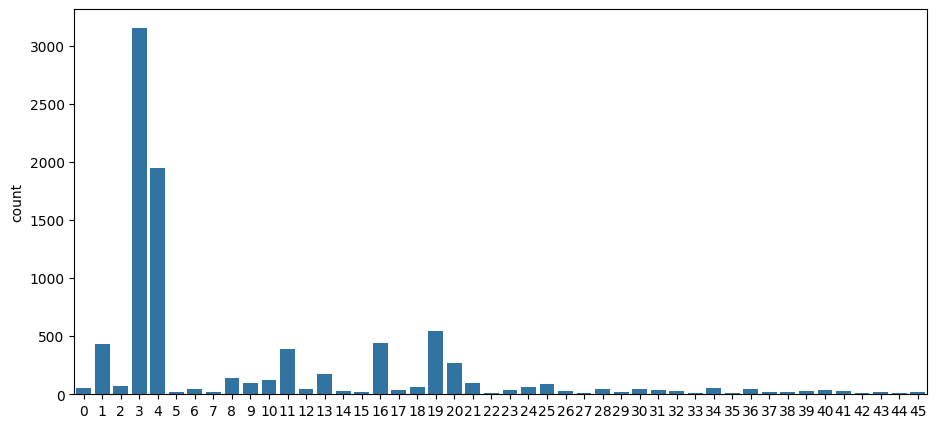

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


In [18]:
check_distribute(x_train, y_train)

## 원본 데이터로 되돌리기

In [19]:
index_to_word = create_index_to_word(reuters)
x_train = index_to_corpus(x_train, index_to_word)
print('X_train:', len(x_train))
print('\n'.join(x_train[:5]))

x_test = index_to_corpus(x_test, index_to_word)
print('X_test:', len(x_test))
print('\n'.join(x_test[:5]))

X_train: 8982
<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
<sos> generale de banque sa lt <unk> br and lt heller overseas corp of chicago have each taken 50 pct stakes in <unk> company sa belgo factors generale de banque said in a statement it gave no financial details of the transaction sa belgo <unk> turnover in 1986 was 17 5 billion belgian francs reuter 3
<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share reflect the two f

## 벡터화

In [20]:
tfidfv, tfidfv_test = vectorizer(x_train, x_test)

print(tfidfv.shape)
print(tfidfv_test.shape)

(8982, 14227)
(2246, 14227)


## 모델링

Multinomial Naive Bayes Classifier
정확도: 0.6331255565449688
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.77      0.53      0.63       105
           2       0.00      0.00      0.00        20
           3       0.77      0.91      0.84       813
           4       0.47      0.96      0.63       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.04      0.08        25
          10       0.00      0.00      0.00        30
          11       0.69      0.40      0.50        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.7

----------------------------------------------------------------------


Complement Naive Bayes Classifier
정확도: 0.7720391807658059
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.65      0.90      0.76       105
           2       0.91      0.50      0.65        20
           3       0.90      0.90      0.90       813
           4       0.76      0.93      0.84       474
           5       0.00      0.00      0.00         5
           6       0.93      0.93      0.93        14
           7       1.00      0.67      0.80         3
           8       0.50      0.13      0.21        38
           9       0.82      0.92      0.87        25
          10       0.96      0.80      0.87        30
          11       0.54      0.71      0.61        83
          12       0.00      0.00      0.00        13
          13       0.60      0.57      0.58        37
          14       0.00      0.00      0.00         2
    

/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


정확도: 0.7871772039180766
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.77      0.71      0.74       105
           2       0.72      0.65      0.68        20
           3       0.91      0.91      0.91       813
           4       0.80      0.84      0.82       474
           5       1.00      0.20      0.33         5
           6       0.81      0.93      0.87        14
           7       1.00      0.33      0.50         3
           8       0.64      0.66      0.65        38
           9       0.81      0.88      0.85        25
          10       0.89      0.80      0.84        30
          11       0.65      0.75      0.69        83
          12       0.38      0.38      0.38        13
          13       0.66      0.57      0.61        37
          14       0.50      1.00      0.67         2
          15       0.67      0.67      0.67         9
          16       0.64      0.77      0.70        99
   

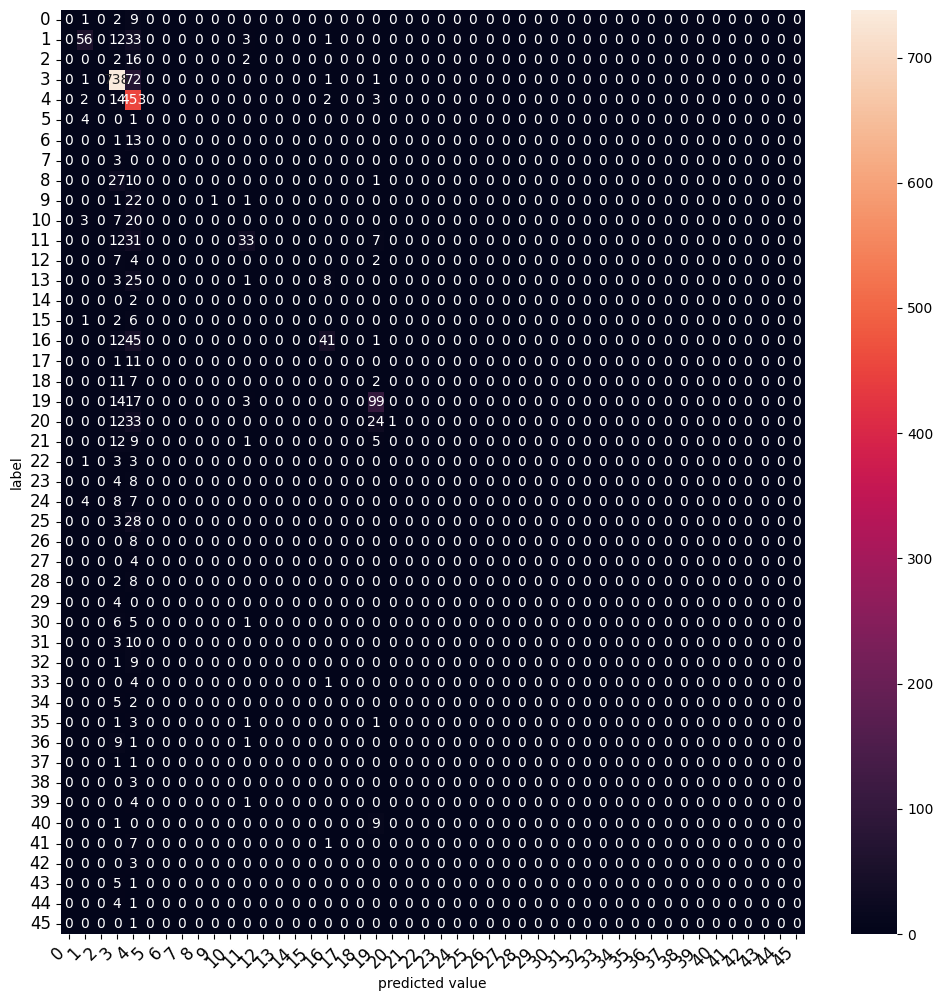

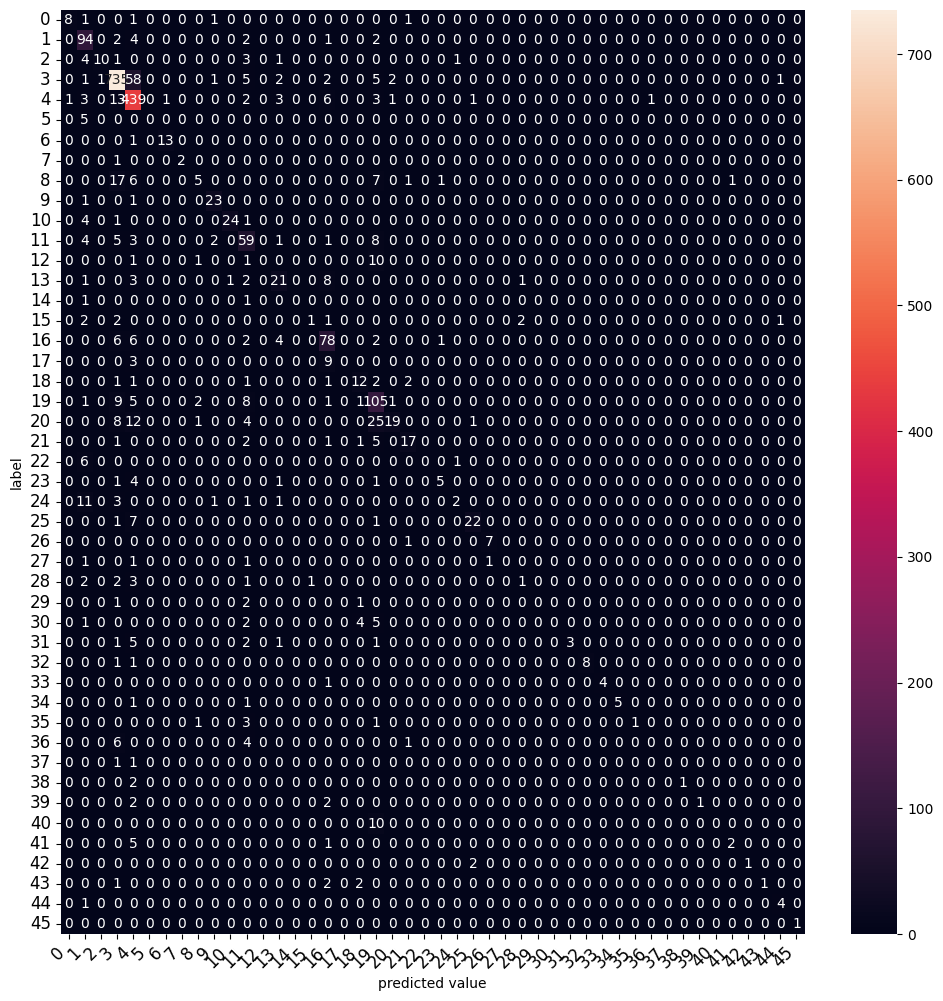

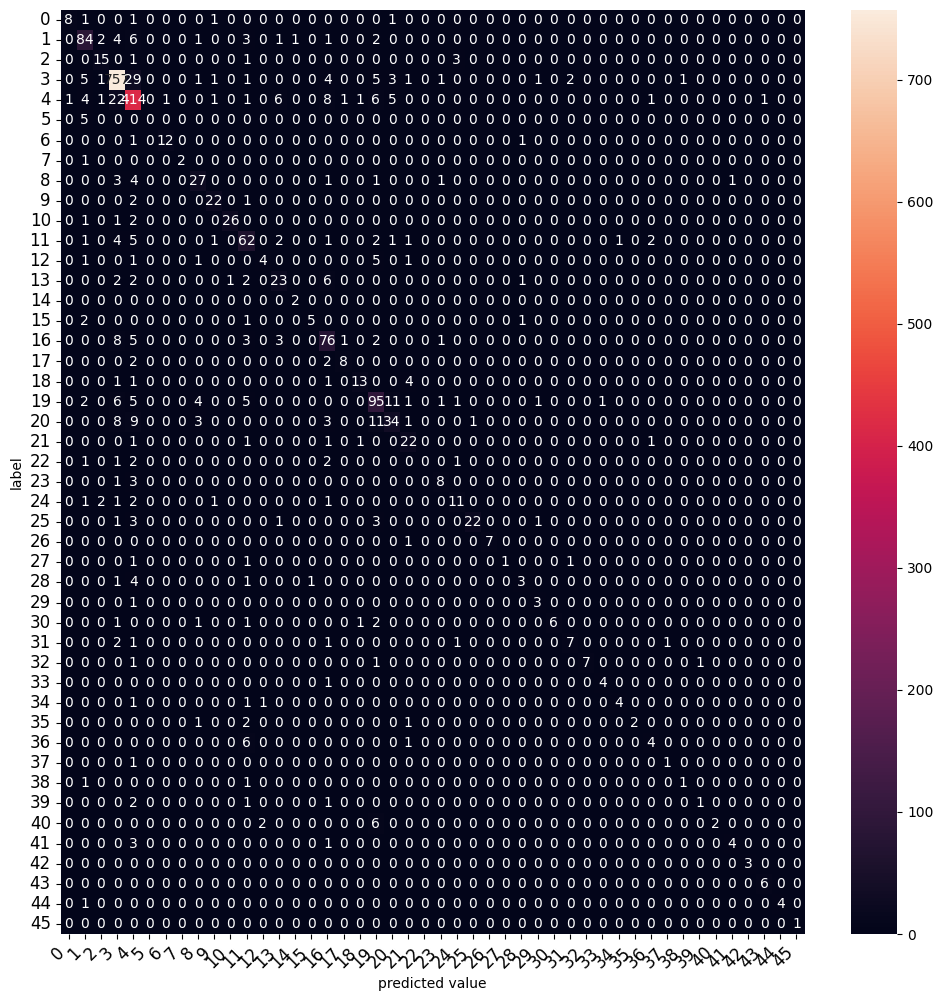

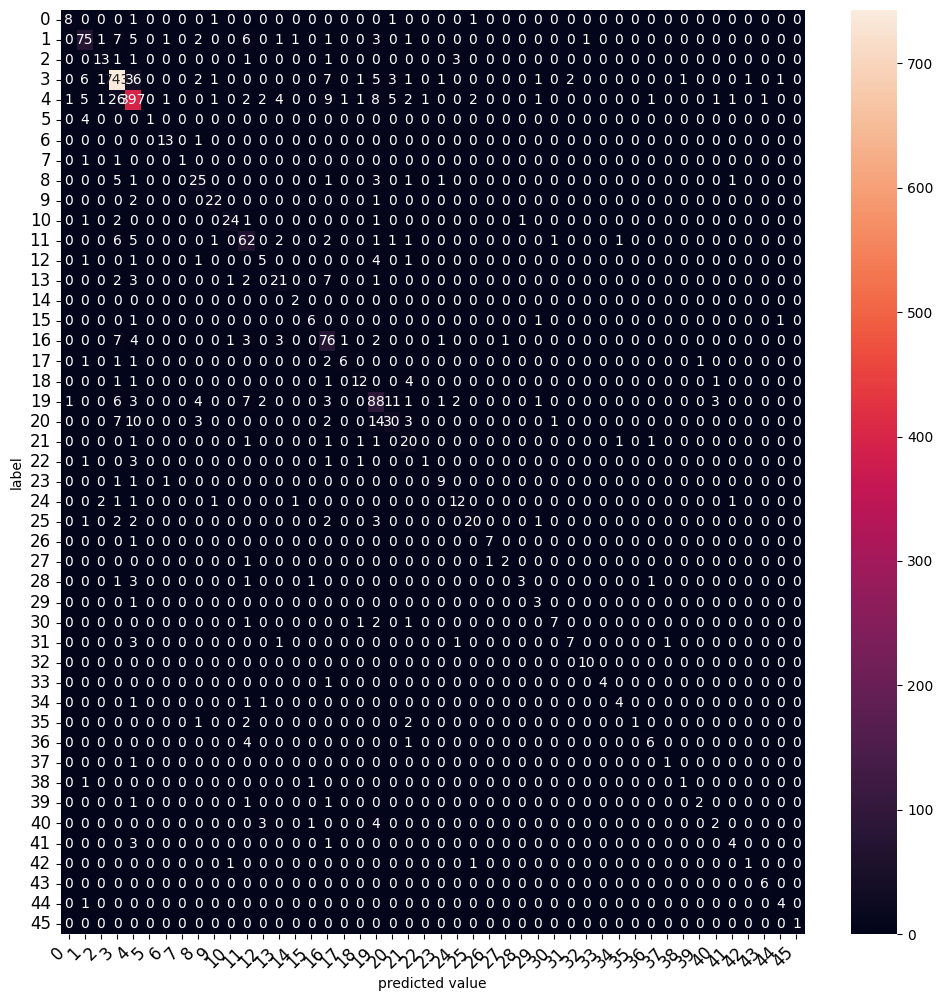

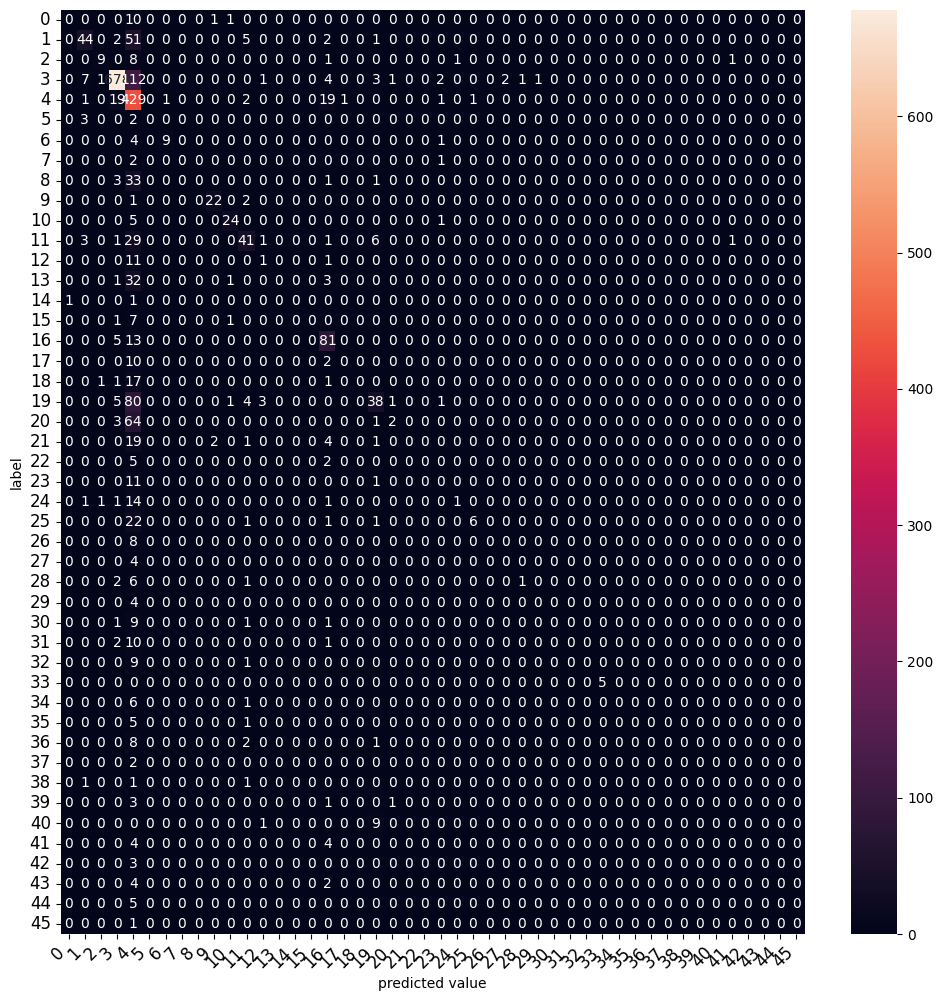

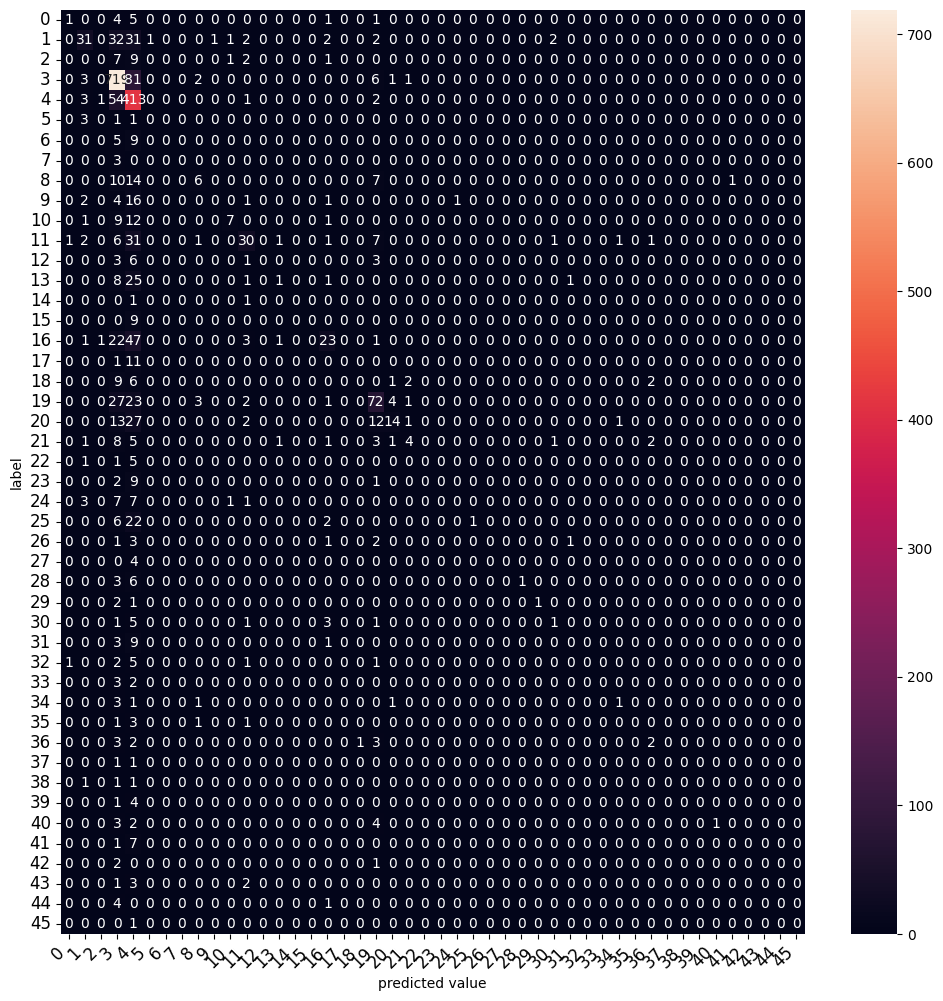

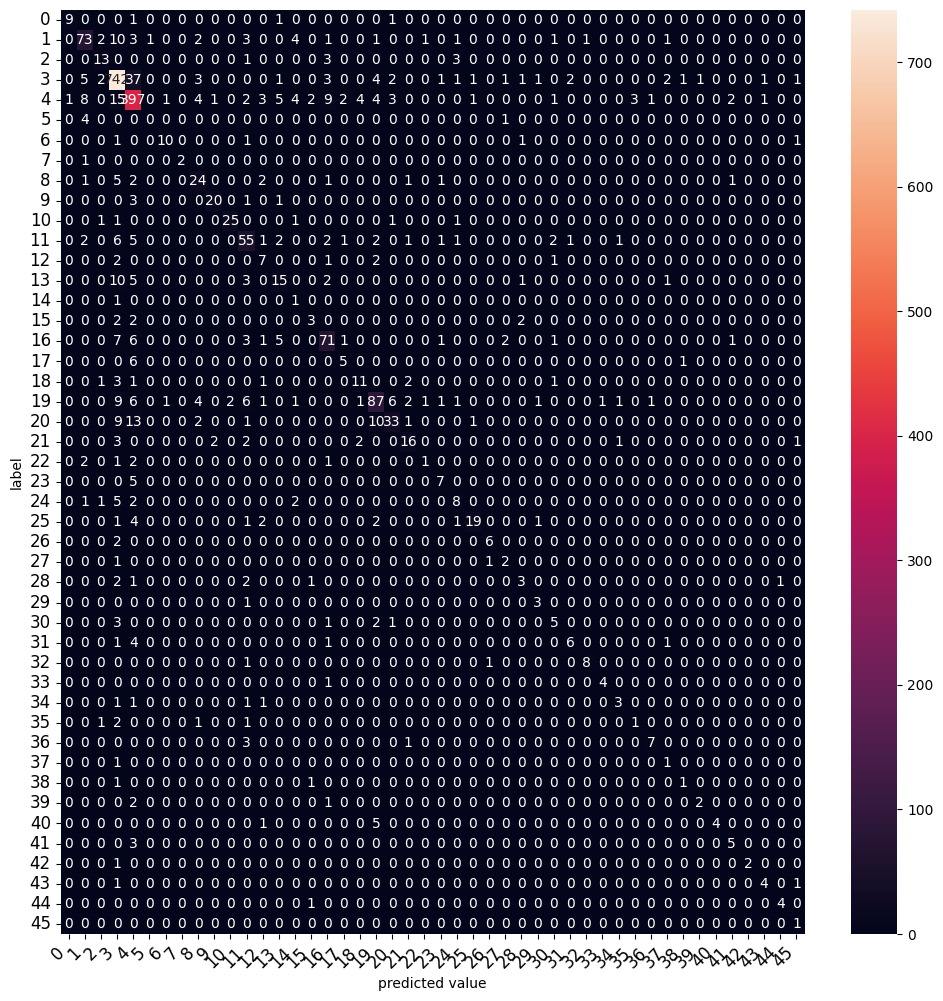

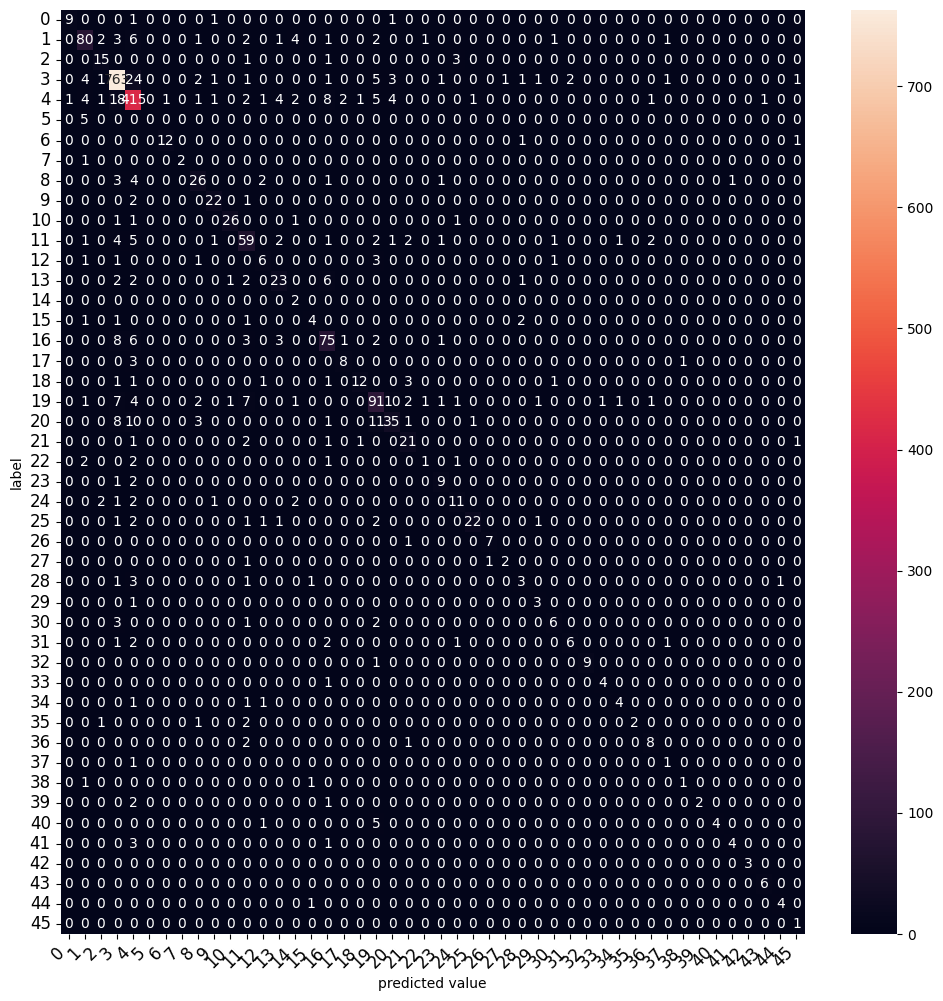

In [21]:
for model_name in model_names:
    print(model_name)
    build_model(models[model_name], tfidfv, y_train, tfidfv_test, y_test)
    print('-' * 70)
    print('\n')

모델은 voting과  Gradient Boosting이 가장 좋아보임.  
단어장의 크기에 따른 정확도 차이가 크게 보이지는 않음.  
원인을 생각해보면 앞의 3,000개 토큰만 보고도 주제 카테고리를 분류하는 건 크게 어렵지 않다고 생긱됨.  
연산량을 고려했을 때 5,000개 정도의 단어장이 적당하다고 생각됨.